# Imports

In [649]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.nn.utils.rnn import pad_sequence

import pandas as pd
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Tokenizer

In [650]:
class Tokenizer:
    def __init__(self, time_count: int = 260, note_count: int = 110, vel_count: int = 2):
        self.val_to_velo_id: dict = {i: i + 1 for i in range(vel_count)}
        self.val_to_note_id: dict = {i: i + 1 + vel_count for i in range(note_count)}
        self.val_to_time_id: dict = {i: i + 1 + vel_count + note_count for i in range(time_count)}

        self.velo_id_to_val: dict = {v: k for k, v in self.val_to_velo_id.items()}
        self.note_id_to_val: dict = {v: k for k, v in self.val_to_note_id.items()}
        self.time_id_to_val: dict = {v: k for k, v in self.val_to_time_id.items()}
        
        self.id_to_token: dict = {
            **{self.val_to_velo_id[i]: f'velo_{i}' for i in self.val_to_velo_id},
            **{self.val_to_note_id[i]: f'note_{i}' for i in self.val_to_note_id},
            **{self.val_to_time_id[i]: f'time_{i}' for i in self.val_to_time_id},
            0: '<pad>',
            vel_count + note_count + time_count + 1: '<bos>',
            vel_count + note_count + time_count + 2: '<eos>'
        }
        
        self.token_to_id: dict = {v: k for k, v in self.id_to_token.items()}
    

    def tuple_to_ids(self, tuple: tuple):
        return [self.val_to_time_id[tuple[0]], self.val_to_note_id[tuple[1]], self.val_to_velo_id[tuple[2]]]
    

    def tuple_list_to_ids(self, tuple_list: list[tuple]):
        l = []
        for t in tuple_list:
            l.extend(self.tuple_to_ids(t))
        return l


    def id_list_to_tuple_list(self, id_list: list[int]):
        l = []
        for i in range(0, len(id_list), 3):
            if i + 3 > len(id_list):
                break
            t = []
            for j, d in enumerate([self.time_id_to_val, self.note_id_to_val, self.velo_id_to_val]):
                if min(d) <= id_list[i+j] <= max(d):
                    t.append(d[id_list[i+j]])
                else:
                    t.append(-1)
            l.append(tuple(t))
        return l

# Dataset

In [651]:
class FrameDataset(Dataset):
    def __init__(self, image_midi_path_pairs: list[tuple], tokenizer: Tokenizer, transform: transforms.Compose = None, max_len = 600):
        self.df = image_midi_path_pairs
        self.tokenizer = tokenizer
        self.transform = transform if transform else transforms.ToTensor()
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.df.iloc[idx]['image']
        midi_path = self.df.iloc[idx]['midi']

        image = Image.open(image_path).convert('L')
        image = self.transform(image)

        midi = pd.read_csv(midi_path)
        midi['time'] = midi['time'] // 10
        midi['velocity'] = (midi['velocity'] > 0).astype(int)
        midi = midi.values.tolist()
        midi = self.tokenizer.tuple_list_to_ids(midi)
        midi.insert(0, self.tokenizer.token_to_id['<bos>'])
        midi.append(self.tokenizer.token_to_id['<eos>'])
        midi.extend([self.tokenizer.token_to_id['<pad>']] * (self.max_len - len(midi)))
        midi = torch.tensor(midi, dtype=torch.long)

        return image, midi

# Helpers

In [ ]:
class ProgressBar:
    def __init__(self, total: int):
        self.total = total
        self.current = 0
        self.last_progress = 0
        self.start_time = time.time()

    def update(self, current: int, epochs: str):
        self.current = current
        progress = (self.current / self.total) * 100
        if int(progress) > self.last_progress:
            elapsed_time = time.time() - self.start_time
            print(
                f'\rEpoch: {epochs.rjust(7)} {str(int(progress)).rjust(3)}% | Elapsed: {str(int(elapsed_time)).rjust(3)}s', end='')
            self.last_progress = int(progress)

In [653]:
class MetricsTracker:
    def __init__(self):
        self.losses = []
        self.accuracies = []

    def update(self, loss: float, accuracy: float):
        self.losses.append(loss)
        self.accuracies.append(accuracy)

    def get_average_loss(self):
        return sum(self.losses) / len(self.losses) if self.losses else 0.0

    def get_average_accuracy(self):
        return sum(self.accuracies) / len(self.accuracies) if self.accuracies else 0.0

In [654]:
class Validator:
    def __init__(self, model: nn.Module, criterion: nn.CrossEntropyLoss, device: torch.device):
        self.model = model
        self.criterion = criterion
        self.device = device

    def validate(self, val_loader: DataLoader) -> tuple:
        self.model.eval()
        metrics_tracker = MetricsTracker()

        with torch.no_grad():
            for image, midi in val_loader:
                image: torch.Tensor = image.to(self.device)
                midi: torch.Tensor = midi.to(self.device)

                input_tokens: torch.Tensor = midi[:, :-1]
                target_tokens: torch.Tensor = midi[:, 1:]
                target_tokens = target_tokens.reshape(-1)

                output: torch.Tensor = self.model(image, input_tokens)
                output = output.reshape(-1, output.shape[-1])

                loss: torch.Tensor = self.criterion(output, target_tokens)
                accuracy = (output.argmax(dim=1) ==
                            target_tokens).float().mean().item()

                metrics_tracker.update(loss.item(), accuracy)

        avg_loss = metrics_tracker.get_average_loss()
        avg_accuracy = metrics_tracker.get_average_accuracy()

        return avg_loss, avg_accuracy

In [655]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 600):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model).to(device)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(np.log(10000.0) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)
    
    def forward(self, x: torch.Tensor):
        x = x + self.encoding[:, :x.size(1), :]
        return x

In [656]:
class TrainingHistory:
    def __init__(self):
        self.history = {
            'train_loss': [],
            'train_accuracy': [],
            'val_loss': [],
            'val_accuracy': []
        }

    def update(self, train_loss: float, train_accuracy: float, val_loss: float, val_accuracy: float):
        self.history['train_loss'].append(train_loss)
        self.history['train_accuracy'].append(train_accuracy)
        self.history['val_loss'].append(val_loss)
        self.history['val_accuracy'].append(val_accuracy)

    def get_history(self):
        return self.history

    def plot(self):
        epochs = range(1, len(self.history['train_loss']) + 1)
        plt.figure(figsize=(12, 6))

        # Plot loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.history['train_loss'], label='Train Loss')
        plt.plot(epochs, self.history['val_loss'], label='Validation Loss')
        plt.title('Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Plot accuracy
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.history['train_accuracy'], label='Train Accuracy')
        plt.plot(epochs, self.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

In [657]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, path='checkpoint.pt', verbose=False):
        self.patience = patience
        self.delta = delta
        self.path = path
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# Train

In [658]:
def train(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    criterion: nn.CrossEntropyLoss,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    device: torch.device = device,
    history: TrainingHistory = None,
    early_stopping: EarlyStopping = None
):
    for epoch in range(epochs):
        progress_bar = ProgressBar(len(train_loader))
        metrics_tracker = MetricsTracker()
        validator = Validator(model, criterion, device)
        model.train()

        for i, (image, midi) in enumerate(train_loader):
            image: torch.Tensor = image.to(device)
            midi: torch.Tensor = midi.to(device)

            input_tokens = midi[:, :-1]
            target_tokens = midi[:, 1:]
            target_tokens = target_tokens.reshape(-1)

            output: torch.Tensor = model(image, input_tokens)
            output = output.reshape(-1, output.shape[-1])

            loss: torch.Tensor = criterion(output, target_tokens)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            accuracy = (output.argmax(dim=1) ==
                        target_tokens).float().mean().item()
            metrics_tracker.update(loss.item(), accuracy)

            progress_bar.update(i + 1, f'{epoch + 1}/{epochs}')

        print(f' | loss: {metrics_tracker.get_average_loss():.4f} - acc: {metrics_tracker.get_average_accuracy():.4f}', end='')
        val_loss, val_acc = validator.validate(val_loader)
        print(f' | val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f}')

        if history:
            history.update(metrics_tracker.get_average_loss(), metrics_tracker.get_average_accuracy(), val_loss, val_acc)
        
        if early_stopping:
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print("Early stopping")
                break

# Model

In [659]:
class PianoTranscriber(nn.Module):
    def __init__(self, input_size: int, vocab_size: int, d_model: int = 128, nhead: int = 2, num_layers: int = 2):
        super(PianoTranscriber, self).__init__()

        self.input_layer = nn.Linear(input_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)

        decoder_layer = nn.TransformerDecoderLayer(d_model, nhead)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers)

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.output = nn.Linear(d_model, vocab_size)

    def forward(self, src: torch.Tensor, tgt: torch.Tensor):
        src = src.flatten(1, 2)
        src = src.permute(0, 2, 1)
        src = self.input_layer(src)
        src = self.pos_encoder(src)
        src = src.permute(1, 0, 2)
        memory = self.encoder(src)

        tgt = self.embedding(tgt)
        tgt = self.pos_encoder(tgt)
        tgt = tgt.permute(1, 0, 2)

        tgt_mask = self.generate_square_subsequent_mask(tgt.size(0)).to(tgt.device)

        output = self.decoder(tgt, memory, tgt_mask=tgt_mask)
        output = self.output(output)
        output = output.permute(1, 0, 2)
        return output

    def generate_square_subsequent_mask(self, sz):
        return torch.triu(torch.full((sz, sz), float('-inf')), diagonal=1)

# Example

### Prep

In [660]:
df = pd.read_csv('dataset.csv')
df['image'] = df['image'].apply(lambda x: os.path.join('dataset', x))
df['midi'] = df['midi'].apply(lambda x: os.path.join('dataset', x))

In [661]:
transform = transforms.Compose([
    transforms.Resize((128, 64)),
    transforms.ToTensor(),
])
tokenizer = Tokenizer()
dataset = FrameDataset(df, tokenizer, transform=transform, max_len=600)
loader = DataLoader(dataset, batch_size=16, num_workers=4, shuffle=True)

### Training

In [662]:
timestamp = time.strftime("%Y%m%d-%H%M%S")

model = PianoTranscriber(128, len(tokenizer.id_to_token)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.token_to_id['<pad>']).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
history = TrainingHistory()
early_stopping = EarlyStopping(patience=5, path=f'model_{timestamp}.pt')

/home/jakub/miniconda3/envs/midi/lib/python3.13/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:
train(model, loader, loader, criterion, optimizer, epochs=100, device=device, history=history, early_stopping=early_stopping)

Epoch:   1/2 100% | Elapsed:   3s | loss: 4.4461 - acc: 0.0620 | val_loss: 3.8623 - val_acc: 0.0651
Epoch:   2/2 100% | Elapsed:   3s | loss: 3.5577 - acc: 0.0694 | val_loss: 3.3020 - val_acc: 0.0734


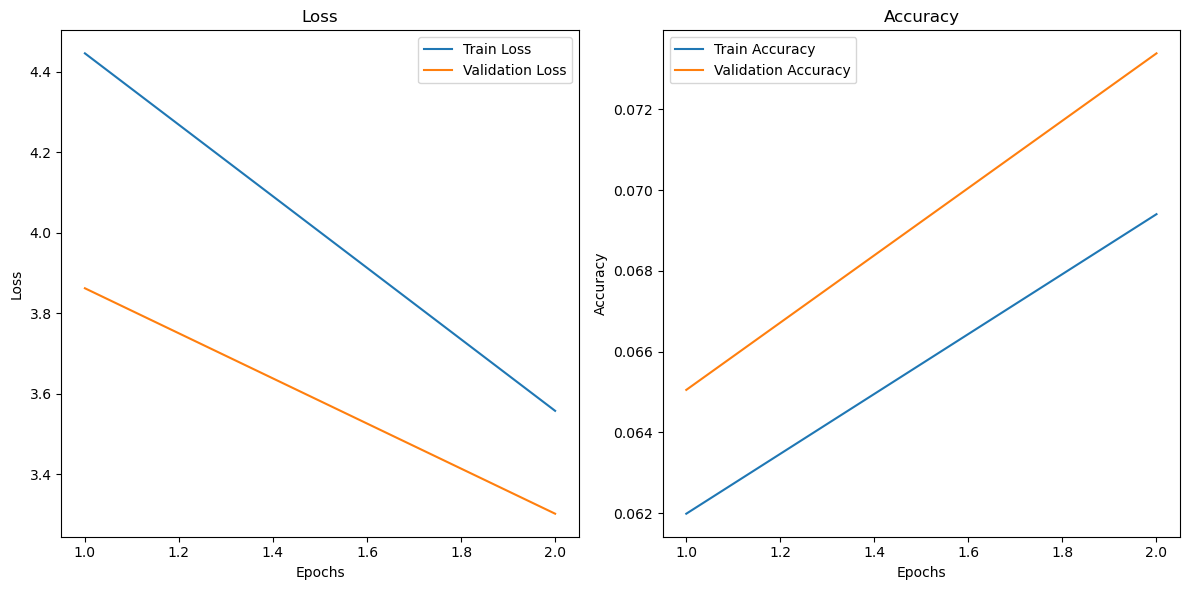

In [664]:
history.plot()